<a href="https://colab.research.google.com/github/linhoangce/tensorflow_learning_stuff/blob/main/automatic_differentiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

# Gradient tapes

TensorFlow provides the `tf.GradientTape` APi for automatic differentiation; that is, computing the gradient of a computation with respect to some inputs, usually `tf.Variable`s. TensorFlow "records" relevant operations executed inside the context of a `tf.GradientTape` onto a "tape". TensorFlow then uses that tape to compute the gradients of a "recorded" computation using reverse mode differentiation.

In [2]:
x = tf.Variable(3.)

with tf.GradientTape() as tape:
  y = x**2

Once some operations are recorded, use `GradientTape.gradient(target, sources)` to calculate the gradient of some target (often a loss) relative to some source (often the model's variables):

In [3]:
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

np.float32(6.0)

In [4]:
# Tensor
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32, name='b'))
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)

To get the gradient of `loss` with respect to both variables, we can pass both as sources to the gradient method. The tape is flexible about how sources are passed and will accept any nested combination of lists or dictionaries and return the gradient structured the same way.

In [5]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])
dl_dw, dl_db

(<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[0.17393541, 1.9080842 ],
        [0.34787083, 3.8161683 ],
        [0.52180624, 5.7242527 ]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.17393541, 1.9080842 ], dtype=float32)>)

In [6]:
w.shape, dl_dw.shape, b.shape, dl_db.shape

(TensorShape([3, 2]), TensorShape([3, 2]), TensorShape([2]), TensorShape([2]))

In [7]:
# calculate gradient with a dictionary of variables passed in
my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.17393541, 1.9080842 ], dtype=float32)>

# Gradients with respect to a model

It's common to collect `tf.Variable` into a `tf.Module` or one of its subclasses (layer.Layer, keras.Model) for checkpointing or exporting.

In most cases, we wull watnt o calculate gradients with respect to a model's trainable variables. Since all subsclasses of `tf.Module` aggregate their vairbales in the `Module.trainable_variables` propety, we can calculate these gradients in a few lines of code:

In [8]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)
  loss = tf.reduce_mean(y**2)


# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)


In [9]:
for var, g in zip(layer.trainable_variables, grad):
  print(f"{var.name}, shape: {g.shape}")

kernel, shape: (3, 2)
bias, shape: (2,)


## Controlling what the tape watches

The default behavior is to record all operations after accessing a trainable `tf.Variable`, because:

* The tape needs to know which operations to record in the forward pass to calculate the gradietns in the backwards pass.

* The tape holds references to intermediate outputs, so we don't want to record unnecessary operations.

* The most common use case involves calculating the gradient of a loss with respect to all of a model's trainable variables.

In [10]:
# This example fails to calculate the gradients because tf.Tensor is not "watched" by default, and tf.Variable is not trainable

# A trainable variable
x0 = tf.Variable(3.0, name='x0')

# Not trainable
x1 = tf.Variable(3., name='x1', trainable=False)

# Not a Variable: A Variable + tensor returns a tensor
x2 = tf.Variable(2., name='x2') + 1.0

# not a Variable
x3 = tf.constant(3., name='x3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2])

for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None


In [11]:
# List the variables being watched by the tape
[var.name for var in tape.watched_variables()]

['x0:0']

`tf.GradientTape` provides hooks that give the user control over what is or is not watched.

To record gradients with respect to a `tf.Tensor`, call `GradientTape.watch()`:

In [15]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x**2

dy_dx = tape.gradient(y, x)
dy_dx.numpy()

np.float32(6.0)

To disable the default behavior of warching all `tf.Variables`, set `watch_accessed_variables=False` when creating the gradient tape. This calculation uses two variables, but only connects the gradient for one of the variables:

In [22]:
x0 = tf.Variable(0.)
x1 = tf.Variable(10.)

with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x1)
  y0 = tf.math.sin(x0)
  y1 = tf.nn.softplus(x1)
  y = y0 + y1
  ys = tf.reduce_sum(y)

Since `GradientTape.watch` was not called on *x0*, no gradient is computed with respect to it:

In [23]:
# dyx/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0,
                          'x1': x1})

print(f"dy/dx0 = {grad['x0']}")
print(f"dy/dx1 = {grad['x1']}")

dy/dx0 = None
dy/dx1 = 0.9999545812606812


## Intermediate results

We can also request gradients of the output with respect to intermediate values computed inside the `tf.GradientTape` context.

In [24]:
x = tf.constant(3.)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x
  z = y * y

# Use the tape to compute the gradient of z with respect to the intermediate value y.
# dx_dy = 2 * y and y = x**2 = 9
tape.gradient(z, y).numpy()

np.float32(18.0)

By default, the resources held by a `GradientTape` are released as soon as the `GradientTape.gradient` method is called. To compute multiple gradients over the same computation, create a gradient tape with `persistent=True`. This allows multiple calls to the gradient method as resources are released when the tape object is garbage collected.

In [29]:
x = tf.constant([1, 3.])

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x*x
  z = y*y

  print(tape.gradient(z, x).numpy())
  print(tape.gradient(y, x).numpy())

[  4. 108.]
[2. 6.]


In [30]:
del tape # Drop the reference to the tape

## Notes on performance

* There is a tiny overhead associated with doing operations inside a gradient tape context. For most eaget execution this will not be a noticeable cost, but we should stil use tape context around the areas only wehre it is required.

* Gradient tapes use memory to store intermediate results, including inputs and outputs, for use during the backward pass.

For efficiency, some ops (like `ReLU`) don't need to keep their intermediate results and they are pruned during the forward pass. However, if `persistent=True` is set on the tape, nothing is discarded and our peak memory usage will be higher.

## Gradients of non-scalar targets

A gradient is fundamentally an operation on a scalar

In [33]:
x = tf.Variable(2.)

with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


Thus, if we ask for the gradient of multiple targets, the result for each source is:

* the gradient of the sum of the targets, or equivalently
* the sum of the gradients of each target

In [35]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y0 = x**2
  y1 = 1 / x

  print(tape.gradient({'y0': y0,
                       'y1': y1}, x).numpy())

3.75


Similarly, if the target(s) are not scalar the gradient of the sum is calculated:

In [37]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.]

print(tape.gradient(y, x).numpy())

7.0


This makes it simple to take the gradient of the sum of a collection of losses, or the gradient of the sum of an element-wise loss calculation.

If we need a separate gradient for each item, we use Jacobian matrix.

In some case we can skip the Jacobian. For an element-wise calculation, the gradient of the sum gives the derivative of each element wiuth respect to its input-element, since each element is independent.

In [38]:
x = tf.linspace(-10., 10., 200+1)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

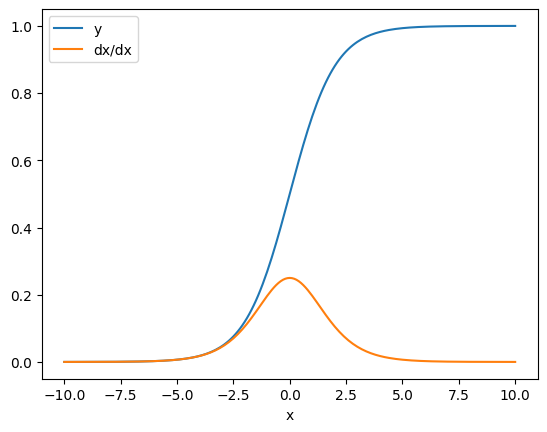

In [40]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dx/dx')
plt.legend()
_= plt.xlabel('x')

## Control flow

Because ta gradient tape recordds operations as they are executed, Python control flow is naturally handled (if and while statement)


In [41]:
x = tf.constant(1.)

v0 = tf.Variable(2.)
v1 = tf.Variable(2.)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  if x > 0.0:
    result = v0
  else:
    result = v1**2

dv0, dv1 = tape.gradient(result, [v0, v1])

dv0, dv1

(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, None)

## Cases where gradient returns **None**

When a target is not connected to a source, `gradient` will return `None`

In [42]:
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y * y
print(tape.gradient(z, x))

None


Here `z` is obvioulsy not connected to `x`, but there are several less-obvious ways that a gradient can be disconnected.

### 1. Replaced a variable with a tensor

One common error is to inadvertently replace a `tf.Variable` with a `tf.Tensor`, instead of using `Variable.assign` to update the `tf.Variable`.

In [45]:
x = tf.Variable(2.)

for epoch in range(2):
  with tf.GradientTape() as tape:
    y = x+1

  print(type(x).__name__, ":", tape.gradient(y, x))
  x = x + 1 # This should `x.assign_add(1)

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None


### 2. Did calculation outside of TensorFlow

The tape can't record the gradient path if the calculation exits TensorFlow.

In [49]:
x = tf.Variable([[1., 2.],
                 [3., 4.]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # This step is calculated with NumPy
  y = np.mean(x2, axis=0)

  # Like most ops, recude_mean will cast the NumPy array to a constant tensor
  # using `tf.convert_to_tensor`
  y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))

None


### 3. Took gradients through an integer or string

Integers and strings are not differentiable. If a calculation path uses these data types there will be no gradient.

Nobody expects strings to be differentiable, but it's easy to accidentally create an `int` constant or variable if we don't specify the `dtype`:


In [50]:
x = tf.constant(10)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))

None


In [51]:
# TensorFlow doesn't automatically cast between types so, in practice, we'll often get a type error instead of missing gradient.
x = tf.constant(10, dtype=tf.float32)

with tf.GradientTape() as g:
  g.watch(x)
  y = x**2

print(g.gradient(y, x))

tf.Tensor(20.0, shape=(), dtype=float32)


### 4. Took gradients through a stateful object

State stops gradients. When we read from stateful object, the tape can only observe the current state, not the history that lead to it.

A `tf.Tensor` is immutable. WE can't change a tensor once it's created. It has a value, but no state. All the operations discussed so far are also stateless: the output of a `tf.matmul` only depends on its inputs.

A `tf.Variable` has internal state - its value. When we use the variable, the state is read. It's normal to calculate a gradient with respect to a variable, but the variable's state blocks gradient calculations from going farther back.

In [54]:
x0 = tf.Variable(3.)
x1 = tf.Variable(0.)

with tf.GradientTape() as tape:
  # Update x1 = x1 + x0
  x1.assign_add(x0)
  # The tape starts recording from x1
  y = x1**2 # y = (x1 + x0) **2

# This doesn't work
print(tape.gradient(y, x0)) # dy/dx0 = 2*(x1 + x0)

None


Similarly, `tf.data.Dataset` iterators and `tf.queue` are stateful, and will stop all gradients on tensors that pass through them.

## No gradients registered

Some `tf.Operation`s are **registered as being non-differentiable** and will return `None`. Others have **no gradient registered**.

If we attempt to take a gradient through a float op that has no gradient registered the tape will throw an error instead of silently returning `None`. This way we know something has gone wrong.

For example, the `tf.image.adjust_contrast` function wraps `raw_ops.AdjustConstrastv2`, which could have a gradient but the gradient is not implemented.

In [57]:
image = tf.Variable([[[0.5, 0., 0.]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
  new_image = tf.image.adjust_contrast(image, delta)

try:
  print(tape.gradient(new_image, [image, delta]))
  assert False; # this should not happen
except LookupError as e:
  print(f'{type(e).__name__} : {e}')

LookupError : gradient registry has no entry for: AdjustContrastv2


If we need to differentiate through this op, we'll either need to implement the gradient and register it (using `tf.RegisterGradient`) or re-implement the function using other ops.

## Zeros instead of None

In some cases it would be convenient to get 0 instead of *None* for unconnected gradients. We can decide what to return when we have unconnected gradients using the `unconnected_gradients` argument:

In [58]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y**2

print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)
